# Key Take-Aways:
- Four diagnostic graphs
- Features to adjust

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# character - integer mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build dataset
block_size = 3 # context length for characters

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and create new context
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
# training, dev and test sets
import random
random.seed(42)
random.shuffle(words)
# break points for a 80, 10, 10 split
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Summary Configuration

In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

In [8]:
# similar to pytorch batchnorm1d

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        #parameters trained with backpropagation
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        #buffers (trianed with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdims=True) # batch mean
            xvar = x.var(0, keepdims=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    


In [9]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [10]:
n_embed = 10 # the dimensionality fo the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)

### #1

In [11]:
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)  
]

### #4 
Compare the effects with out the activation layers, with no Tanh:

- causes the activation and gradient distributions to spread out

In [12]:
# layers = [
#     Linear(n_embed * block_size, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden),
#     Linear(n_hidden, n_hidden),
#     Linear(n_hidden, n_hidden),
#     Linear(n_hidden, n_hidden),
#     Linear(n_hidden, vocab_size)  
# ]

### #2

In [13]:
with torch.no_grad():
    # last layer: make it less confident
    layers[-1].weight *= 0.1
    
    # all other layers: apply gain -- gain specific to the Linear/Tanh configuration
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # compare the saturation graphs in #3
            layer.weight *= 5/3
#            layer.weight *= 0.5 # 3 # 1


In [14]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [15]:
# same optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x) # the values from C specific to the batch as an argument to the layer functions, #1
    loss = F.cross_entropy(x, Yb) # loss function
    # more on cross_entropy: https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
    # https://machinelearningmastery.com/cross-entropy-for-machine-learning/
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update 
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    if i > 1000:
        break

      0/ 200000: 3.2962


### #3
Observe the effects of the different layer weights from #2 

layer  1 (      Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer  3 (      Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer  5 (      Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer  7 (      Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer  9 (      Tanh): mean -0.01, std 0.71, saturated: 11.22%


Text(0.5, 1.0, 'Activation distribution')

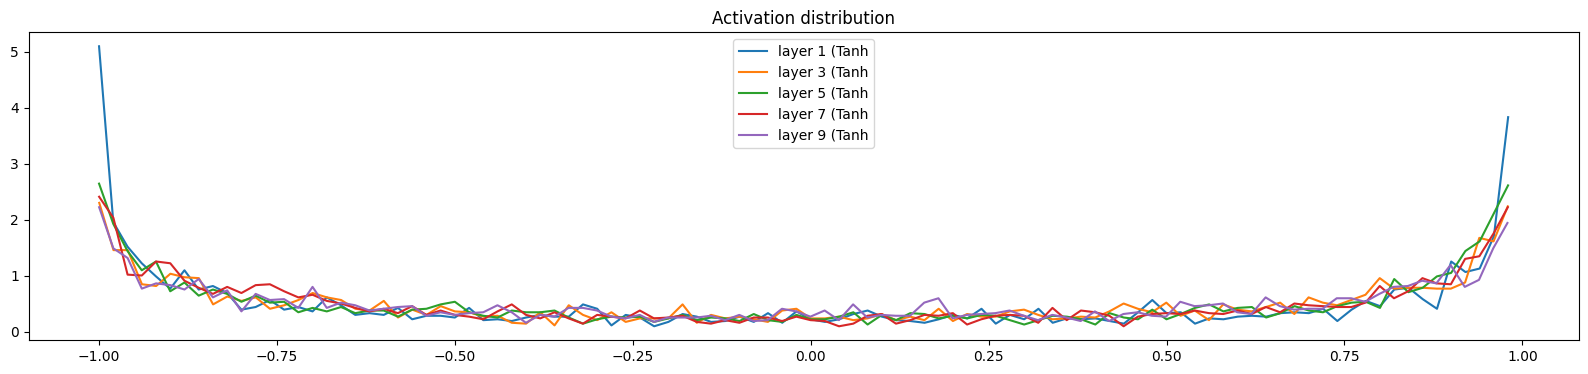

In [16]:
# visualize the histograms
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
     if isinstance(layer, Tanh):
#    if isinstance(layer, Linear): # scenario #4
        
        t = layer.out
        print('layer % d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("Activation distribution")

layer  1 (      Tanh): mean -0.000005, std 3.059084e-03
layer  3 (      Tanh): mean +0.000037, std 3.085332e-03
layer  5 (      Tanh): mean -0.000007, std 2.888205e-03
layer  7 (      Tanh): mean +0.000012, std 2.756316e-03
layer  9 (      Tanh): mean +0.000007, std 2.337389e-03


Text(0.5, 1.0, 'Gradient distribution')

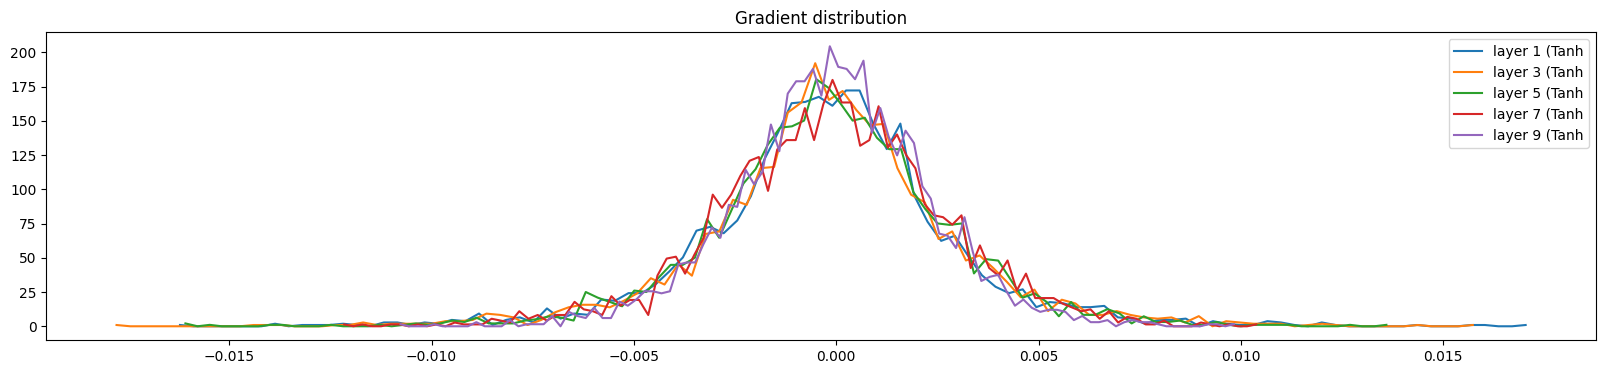

In [17]:
# visualize the histograms
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
#    if isinstance(layer, Linear): # scenario #4 

        t = layer.out.grad
        print('layer % d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("Gradient distribution")

### Look at the weights of the linear layers:

weight   (27, 10) | mean +0.000772 | std 9.714616e-03 | grad: data ratio 9.714502e-03
weight  (30, 100) | mean -0.000036 | std 8.734044e-03 | grad: data ratio 2.792835e-02
weight (100, 100) | mean +0.000085 | std 7.424625e-03 | grad: data ratio 4.417370e-02
weight (100, 100) | mean +0.000055 | std 6.242010e-03 | grad: data ratio 3.681916e-02
weight (100, 100) | mean +0.000007 | std 6.161662e-03 | grad: data ratio 3.650615e-02
weight (100, 100) | mean +0.000069 | std 5.221999e-03 | grad: data ratio 3.102274e-02
weight  (100, 27) | mean +0.000000 | std 2.281147e-02 | grad: data ratio 3.229573e-01


Text(0.5, 1.0, 'Weights gradient distribution')

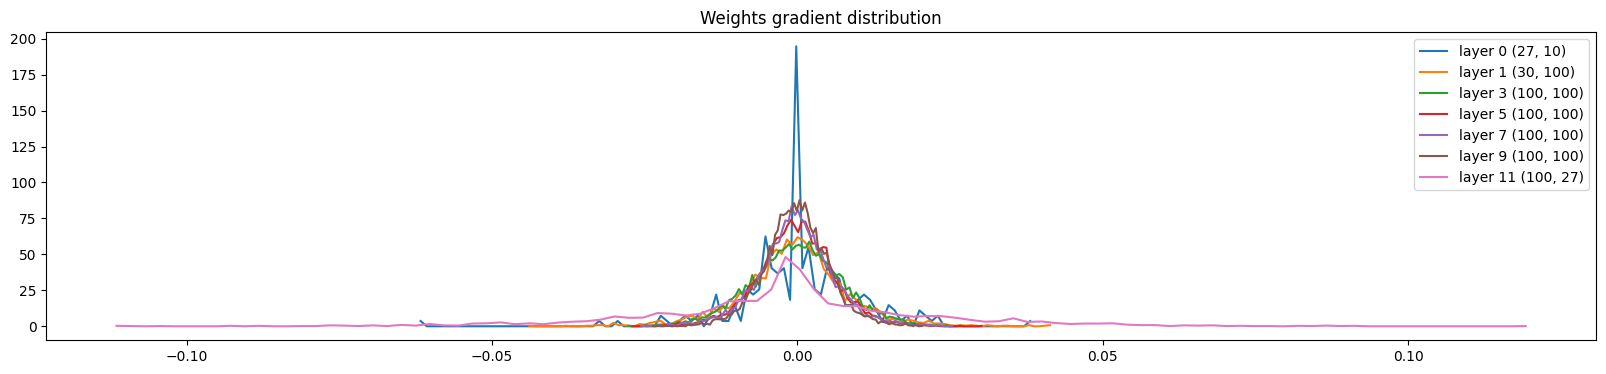

In [18]:
# visualize the histograms
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        # t.std()/p/std() is the ratio of the gradient to the data at the given layer
        print('weight %10s | mean %+f | std %e | grad: data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Weights gradient distribution")

## Additional visualization: track the changes in the updates to the gradient, update to data (ud)

In [19]:
# same optimization
max_steps = 200000
batch_size = 32
lossi = []

# update to data
ud = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x) # the values from C specific to the batch as an argument to the layer functions, #1
    loss = F.cross_entropy(x, Yb) # loss function
    # more on cross_entropy: https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
    # https://machinelearningmastery.com/cross-entropy-for-machine-learning/
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update 
    # 5 Compare the effect of a lower learning rate ; changes to the updates are much lower (1e-5);
    # the effect of training too slow
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
#    lr = 0.001 if i < 100000 else 0.01 # step learning rate decay

    
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    # track the changes to the updates of the gradient
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i > 1000:
        break

      0/ 200000: 2.0273


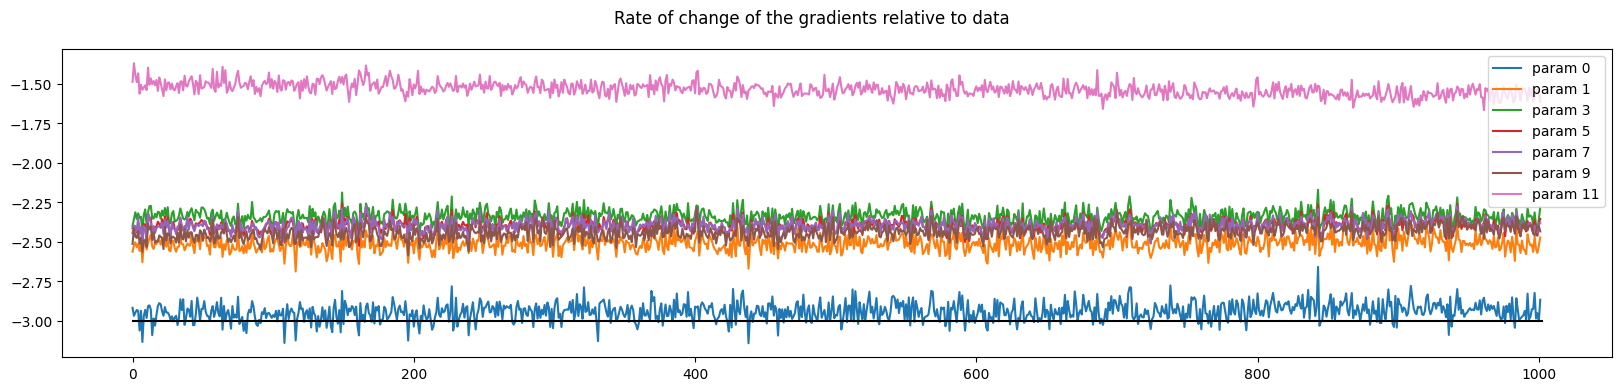

In [20]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these values should be ~1e-3 so indicate it on the plot

plt.suptitle("Rate of change of the gradients relative to data")
plt.legend(legends)
plt.show()

## With Batch Normalization

In [22]:
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size),  BatchNorm1d(vocab_size),
]

In [23]:
with torch.no_grad():
    # last layer: make it less confident
    layers[-1].gamma *= 0.1  # gamma is the factor from batch normalization that interacts with the layer
    
    # all other layers: apply gain -- gain specific to the Linear/Tanh configuration
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # compare the saturation graphs in #3
            layer.weight *= 5/3
#            layer.weight *= 0.5 # 3 # 1


In [24]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [25]:
# same optimization
max_steps = 200000
batch_size = 32
lossi = []

# update to data
ud = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x) # the values from C specific to the batch as an argument to the layer functions, #1
    loss = F.cross_entropy(x, Yb) # loss function
    # more on cross_entropy: https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
    # https://machinelearningmastery.com/cross-entropy-for-machine-learning/
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update 
    # 5 Compare the effect of a lower learning rate ; changes to the updates are much lower (1e-5);
    # the effect of training too slow
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
#    lr = 0.001 if i < 100000 else 0.01 # step learning rate decay

    
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    # track the changes to the updates of the gradient
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i > 1000:
        break

      0/ 200000: 3.3118


layer  2 (      Tanh): mean +0.00, std 0.63, saturated: 2.69%
layer  5 (      Tanh): mean -0.00, std 0.65, saturated: 1.66%
layer  8 (      Tanh): mean +0.00, std 0.64, saturated: 2.16%
layer  11 (      Tanh): mean +0.00, std 0.65, saturated: 2.09%
layer  14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'Activation distribution')

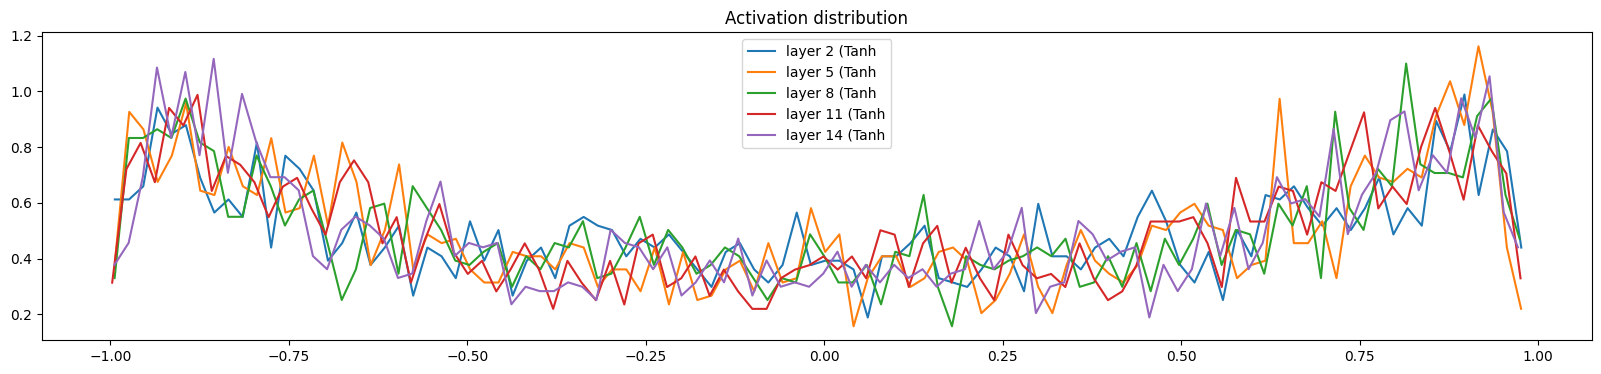

In [26]:
# visualize the histograms
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
     if isinstance(layer, Tanh):
#    if isinstance(layer, Linear): # scenario #4
        
        t = layer.out
        print('layer % d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("Activation distribution")

layer  2 (      Tanh): mean -0.000000, std 3.569793e-03
layer  5 (      Tanh): mean -0.000000, std 3.084934e-03
layer  8 (      Tanh): mean -0.000000, std 2.761322e-03
layer  11 (      Tanh): mean +0.000000, std 2.636435e-03
layer  14 (      Tanh): mean +0.000000, std 2.568243e-03


Text(0.5, 1.0, 'Gradient distribution')

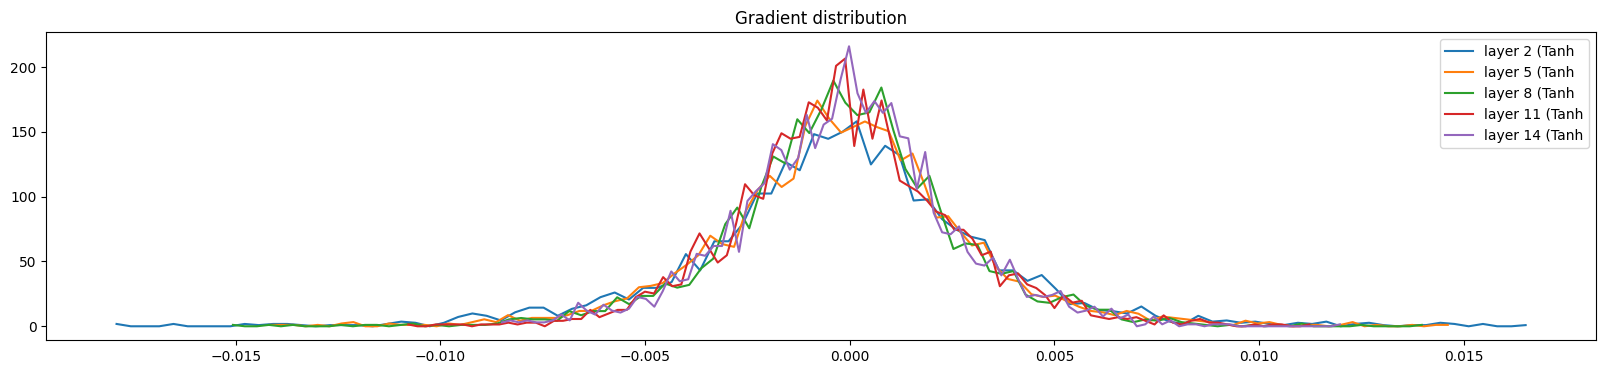

In [27]:
# visualize the histograms
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
#    if isinstance(layer, Linear): # scenario #4 

        t = layer.out.grad
        print('layer % d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("Gradient distribution")

weight   (27, 10) | mean -0.000000 | std 1.073997e-02 | grad: data ratio 1.069982e-02
weight  (30, 100) | mean -0.000039 | std 8.684371e-03 | grad: data ratio 2.762019e-02
weight (100, 100) | mean +0.000036 | std 6.828525e-03 | grad: data ratio 4.060234e-02
weight (100, 100) | mean +0.000059 | std 5.938996e-03 | grad: data ratio 3.566519e-02
weight (100, 100) | mean +0.000013 | std 5.181987e-03 | grad: data ratio 3.052931e-02
weight (100, 100) | mean +0.000126 | std 4.946658e-03 | grad: data ratio 2.970809e-02
weight  (100, 27) | mean -0.000096 | std 9.465607e-03 | grad: data ratio 5.754814e-02


Text(0.5, 1.0, 'Weights gradient distribution')

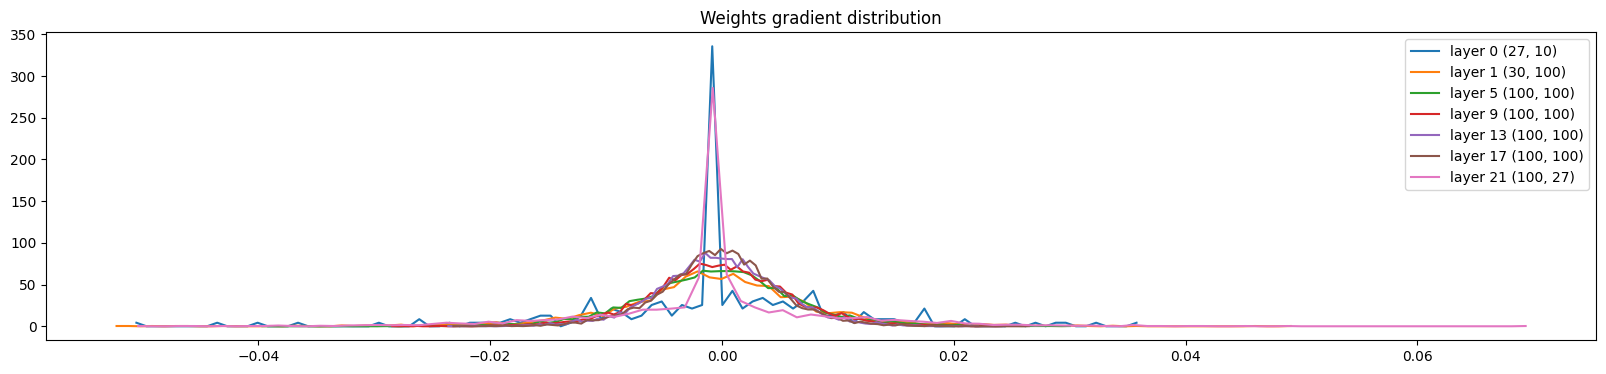

In [28]:
# visualize the histograms
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        # t.std()/p/std() is the ratio of the gradient to the data at the given layer
        print('weight %10s | mean %+f | std %e | grad: data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Weights gradient distribution")

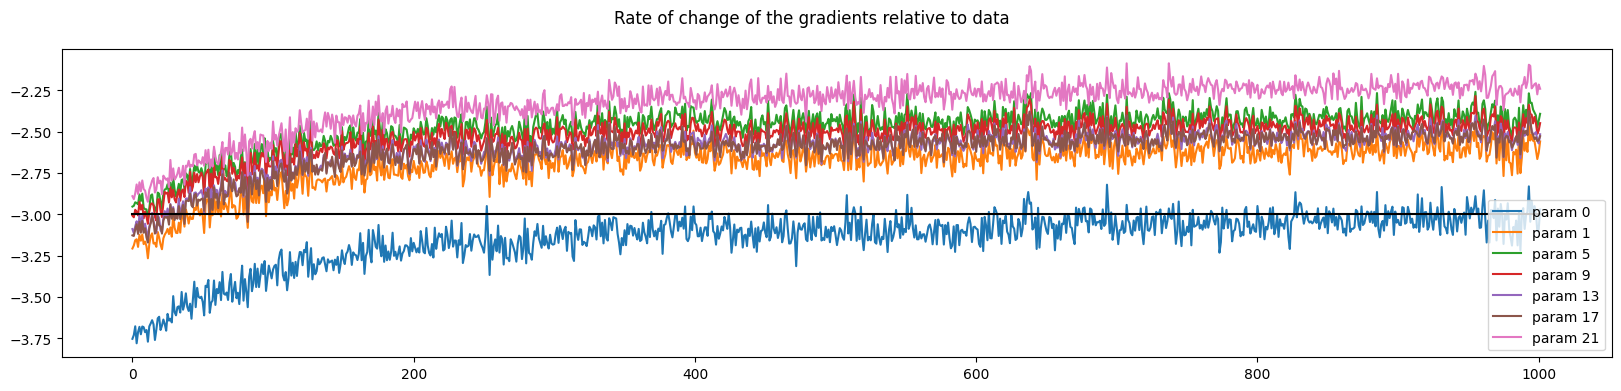

In [29]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these values should be ~1e-3 so indicate it on the plot

plt.suptitle("Rate of change of the gradients relative to data")
plt.legend(legends)
plt.show()